# MFCC

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import json
import os
import math

from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt

In [ ]:
DATASET_PATH = "sound - robot"
JSON_PATH = "model_robot/data_sound.json"
SAMPLE_RATE = 16000
TRACK_DURATION = 1 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
train_audio_path = r'G:\Python\Lenh_dieu_khien\sound - robot'
labels=os.listdir(train_audio_path)

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                mfcc = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T

                if len(mfcc) == num_mfcc_vectors_per_segment:
                    data["mfcc"].append(mfcc.tolist())
                    data["labels"].append(i-1)
                    print("{}".format(file_path))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)

# Data Load

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = "model_robot/data_sound.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

# Conv2D

In [ ]:
X, y = load_data(DATA_PATH)

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
#X_train = X_train[..., np.newaxis]
#X_validation = X_validation[..., np.newaxis]
#X_test = X_test[..., np.newaxis]

In [ ]:
input_shape = (None, 13)

In [243]:
# build the CNN
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
model_cnn.add(keras.layers.LSTM(64))
model_cnn.add(keras.layers.Dense(32, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))
model_cnn.add(keras.layers.Dense(4, activation='softmax'))

In [244]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [245]:
model_cnn.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, None, 128)         72704     
_________________________________________________________________
lstm_50 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_50 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 132       
Total params: 124,324
Trainable params: 124,324
Non-trainable params: 0
_________________________________________________________________


In [246]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
8/8 [==============================] - 3s 121ms/step - loss: 1.4079 - accuracy: 0.2418 - val_loss: 1.3708 - val_accuracy: 0.3281
Epoch 2/50
8/8 [==============================] - 0s 26ms/step - loss: 1.4148 - accuracy: 0.2233 - val_loss: 1.3515 - val_accuracy: 0.3750
Epoch 3/50
8/8 [==============================] - 0s 26ms/step - loss: 1.3668 - accuracy: 0.2807 - val_loss: 1.3374 - val_accuracy: 0.4219
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 1.3449 - accuracy: 0.3352 - val_loss: 1.3217 - val_accuracy: 0.4844
Epoch 5/50
8/8 [==============================] - 0s 26ms/step - loss: 1.3307 - accuracy: 0.3780 - val_loss: 1.3037 - val_accuracy: 0.4688
Epoch 6/50
8/8 [==============================] - 0s 26ms/step - loss: 1.3228 - accuracy: 0.3957 - val_loss: 1.2852 - val_accuracy: 0.5000
Epoch 7/50
8/8 [==============================] - ETA: 0s - loss: 1.2932 - accuracy: 0.46 - 0s 26ms/step - loss: 1.2898 - accuracy: 0.4736 - val_loss: 1.2651 - val_a

In [247]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.savefig('plot.png')
    plt.show()

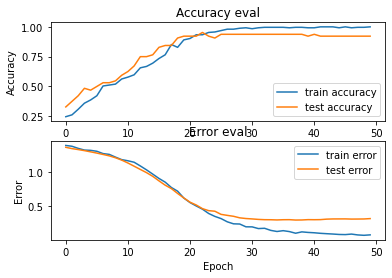

In [248]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [249]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

3/3 - 1s - loss: 0.2640 - accuracy: 0.9375

Test accuracy: 0.9375


In [250]:
model_cnn.save("model_sum/MFCC_LSTM.h5")